# SWIN Transformer 모델

In [1]:
# 라이브러리 불러오기
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from transformers import (
    SwinForImageClassification, 
    SwinConfig,
    TrainingArguments, 
    Trainer,
    AutoImageProcessor,
    EarlyStoppingCallback
)

import numpy as np
from sklearn.metrics import accuracy_score
import json

# GPU 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ 사용 디바이스: {DEVICE}")

/workspace/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 사용 디바이스: cuda


In [2]:
# 경로 설정
PHOTO_DATA_PATH_TRAIN = "/workspace/datasets/dataset2yolo/photo/train"
PHOTO_DATA_PATH_VAL = "/workspace/datasets/dataset2yolo/photo/val"
DRAWING_DATA_PATH_TRAIN = "/workspace/datasets/dataset2yolo/drawing/train"
DRAWING_DATA_PATH_VAL = "/workspace/datasets/dataset2yolo/drawing/val"
PRETRAINED_MODEL_PATH = "/workspace/models/photo_pretrained_swin"
FINAL_MODEL_PATH = "/workspace/models/drawing_finetuned_swin"
TEST_FOLDER_PATH = "/workspace/testImg/val"  # 테스트 이미지 폴더 경로 설정

# 하이퍼파라미터
EPOCHS_PHOTO = 10
EPOCHS_DRAWING = 200
BATCH_SIZE = 32
IMG_SIZE = 224
LR = 1e-4
PATIENCE = 7

In [9]:
class ImageClassificationDataset(Dataset):
    def __init__(self, data_path, processor, is_training=True):
        self.data_path = data_path
        self.processor = processor
        self.is_training = is_training
        
        # 클래스 폴더에서 이미지 경로와 라벨 수집
        self.images = []
        self.labels = []
        self.class_names = sorted(os.listdir(data_path))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}
        
        for class_name in self.class_names:
            class_path = os.path.join(data_path, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_to_idx[class_name])
        
        print(f"📊 데이터셋 정보 ({data_path}): {len(self.images)}개 이미지, {len(self.class_names)}개 클래스")
        print(f"📋 클래스: {self.class_names}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        
        # 이미지 로드
        image = Image.open(image_path).convert('RGB')
        
        # 전처리
        inputs = self.processor(image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)
        
        return {
            'pixel_values': pixel_values,
            'labels': torch.tensor(label, dtype=torch.long)
        }

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}

def create_trainer(model, train_dataset, eval_dataset, output_dir, epochs, learning_rate):
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=learning_rate,
        weight_decay=0.01,
        logging_dir=f'{output_dir}/logs',
        logging_steps=10,
        eval_strategy="epoch",  # evaluation_strategy -> eval_strategy
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        save_total_limit=3,
        dataloader_num_workers=4,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to=None,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)]
    )
    
    return trainer

# 이미지 프로세서 초기화
processor = AutoImageProcessor.from_pretrained("microsoft/swin-base-patch4-window7-224")

In [10]:
# 1️⃣ Step 1 - 사진 데이터로 사전학습
print("\n🔵 Step 1: 사진 데이터로 SWIN Transformer 학습")

# 사진 데이터셋 생성 (train/val 분리)
photo_train_dataset = ImageClassificationDataset(PHOTO_DATA_PATH_TRAIN, processor, is_training=True)
photo_eval_dataset = ImageClassificationDataset(PHOTO_DATA_PATH_VAL, processor, is_training=False)
num_classes = len(photo_train_dataset.class_names)

# 클래스 일치성 확인
if photo_train_dataset.class_names != photo_eval_dataset.class_names:
    print("⚠️  WARNING: Train과 Val 데이터셋의 클래스가 다릅니다!")
    print(f"Train classes: {photo_train_dataset.class_names}")
    print(f"Val classes: {photo_eval_dataset.class_names}")

# SWIN 모델 초기화
model_config = SwinConfig.from_pretrained("microsoft/swin-base-patch4-window7-224")
model_config.num_labels = num_classes
model1 = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    config=model_config,
    ignore_mismatched_sizes=True
)

# Trainer 생성 및 학습
trainer1 = create_trainer(
    model1, 
    photo_train_dataset, 
    photo_eval_dataset, 
    PRETRAINED_MODEL_PATH,
    EPOCHS_PHOTO,
    LR
)

# 학습 실행
print("🚀 사진 데이터 학습 시작...")
trainer1.train()

# 모델 저장
trainer1.save_model(PRETRAINED_MODEL_PATH)
processor.save_pretrained(PRETRAINED_MODEL_PATH)

# 클래스 정보 저장
class_info = {
    'class_names': photo_train_dataset.class_names,
    'class_to_idx': photo_train_dataset.class_to_idx,
    'num_classes': num_classes
}
with open(os.path.join(PRETRAINED_MODEL_PATH, 'class_info.json'), 'w') as f:
    json.dump(class_info, f, indent=2)

print(f"📁 사진 기반 사전학습 모델 저장 완료: {PRETRAINED_MODEL_PATH}")



🔵 Step 1: 사진 데이터로 SWIN Transformer 학습
📊 데이터셋 정보 (/workspace/datasets/dataset2yolo/photo/train): 5756개 이미지, 4개 클래스
📋 클래스: ['angry', 'fear', 'happy', 'sad']
📊 데이터셋 정보 (/workspace/datasets/dataset2yolo/photo/val): 1440개 이미지, 4개 클래스
📋 클래스: ['angry', 'fear', 'happy', 'sad']


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([4, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 사진 데이터 학습 시작...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.655100,0.666216,0.760417
2,0.408400,0.585478,0.777083
3,0.187200,0.569281,0.801389
4,0.114700,0.810970,0.821528
5,0.094900,1.132816,0.825000
6,0.071500,1.519773,0.810417
7,0.002100,1.378435,0.833333
8,0.000000,1.583768,0.821528
9,0.000100,1.595492,0.828472
10,0.000000,1.589001,0.826389


📁 사진 기반 사전학습 모델 저장 완료: /workspace/models/photo_pretrained_swin


In [11]:
# 2️⃣ Step 2 - 그림 데이터 파인튜닝
print("\n🟣 Step 2: 그림 데이터로 파인튜닝")

# 그림 데이터셋 생성 (train/val 분리)
drawing_train_dataset = ImageClassificationDataset(DRAWING_DATA_PATH_TRAIN, processor, is_training=True)
drawing_eval_dataset = ImageClassificationDataset(DRAWING_DATA_PATH_VAL, processor, is_training=False)
drawing_num_classes = len(drawing_train_dataset.class_names)

# 클래스 일치성 확인
if drawing_train_dataset.class_names != drawing_eval_dataset.class_names:
    print("⚠️  WARNING: Train과 Val 데이터셋의 클래스가 다릅니다!")
    print(f"Train classes: {drawing_train_dataset.class_names}")
    print(f"Val classes: {drawing_eval_dataset.class_names}")

print(f"📊 그림 데이터 클래스 수: {drawing_num_classes}")

# 사전학습된 모델 불러오기
model2 = SwinForImageClassification.from_pretrained(PRETRAINED_MODEL_PATH)

# 클래스 수가 다르다면 분류 헤드 조정
if drawing_num_classes != num_classes:
    print(f"⚠️  클래스 수 변경: {num_classes} -> {drawing_num_classes}")
    model2.classifier = nn.Linear(model2.config.hidden_size, drawing_num_classes)
    model2.num_labels = drawing_num_classes

# 파인튜닝을 위한 Trainer 생성 (더 낮은 학습률 사용)
trainer2 = create_trainer(
    model2,
    drawing_train_dataset,
    drawing_eval_dataset,
    FINAL_MODEL_PATH,
    EPOCHS_DRAWING,
    LR * 0.1  # 파인튜닝시 더 낮은 학습률 사용
)

# 파인튜닝 실행
print("🚀 그림 데이터 파인튜닝 시작...")
trainer2.train()

# 파인튜닝된 모델 저장
trainer2.save_model(FINAL_MODEL_PATH)
processor.save_pretrained(FINAL_MODEL_PATH)

# 그림 데이터의 클래스 정보 저장
drawing_class_info = {
    'class_names': drawing_train_dataset.class_names,
    'class_to_idx': drawing_train_dataset.class_to_idx,
    'num_classes': drawing_num_classes
}
with open(os.path.join(FINAL_MODEL_PATH, 'class_info.json'), 'w') as f:
    json.dump(drawing_class_info, f, indent=2)

print(f"📁 파인튜닝된 모델 저장 완료: {FINAL_MODEL_PATH}")


🟣 Step 2: 그림 데이터로 파인튜닝
📊 데이터셋 정보 (/workspace/datasets/dataset2yolo/drawing/train): 1522개 이미지, 4개 클래스
📋 클래스: ['angry', 'fear', 'happy', 'sad']
📊 데이터셋 정보 (/workspace/datasets/dataset2yolo/drawing/val): 469개 이미지, 4개 클래스
📋 클래스: ['angry', 'fear', 'happy', 'sad']
📊 그림 데이터 클래스 수: 4
🚀 그림 데이터 파인튜닝 시작...


Epoch,Training Loss,Validation Loss,Accuracy
1,1.150800,0.986343,0.626866
2,0.835700,0.791737,0.718550
3,0.606700,0.631262,0.784648
4,0.395800,0.581561,0.829424
5,0.379200,0.543001,0.835821
6,0.243200,0.572505,0.835821
7,0.246100,0.596164,0.844350
8,0.148800,0.710649,0.852878
9,0.168700,0.659048,0.850746
10,0.143200,0.671837,0.846482


📁 파인튜닝된 모델 저장 완료: /workspace/models/drawing_finetuned_swin


In [12]:
# 모델 평가
print("\n📊 최종 모델 평가")

# 최종 모델로 평가
final_results = trainer2.evaluate()
print("🎯 최종 성능:")
for key, value in final_results.items():
    print(f"  {key}: {value:.4f}")

print("\n✅ 모든 학습 과정이 완료되었습니다!")
print(f"📁 최종 모델 경로: {FINAL_MODEL_PATH}")


📊 최종 모델 평가


🎯 최종 성능:
  eval_loss: 0.6615
  eval_accuracy: 0.8571
  eval_runtime: 2.9827
  eval_samples_per_second: 157.2410
  eval_steps_per_second: 5.0290
  epoch: 20.0000

✅ 모든 학습 과정이 완료되었습니다!
📁 최종 모델 경로: /workspace/models/drawing_finetuned_swin



🔍 테스트 결과 시각화 (12개 이미지)
🔄 모델 로딩 중...


📊 12개 테스트 이미지 처리 중...
🎯 테스트 정확도: 0.2500 (3/12)


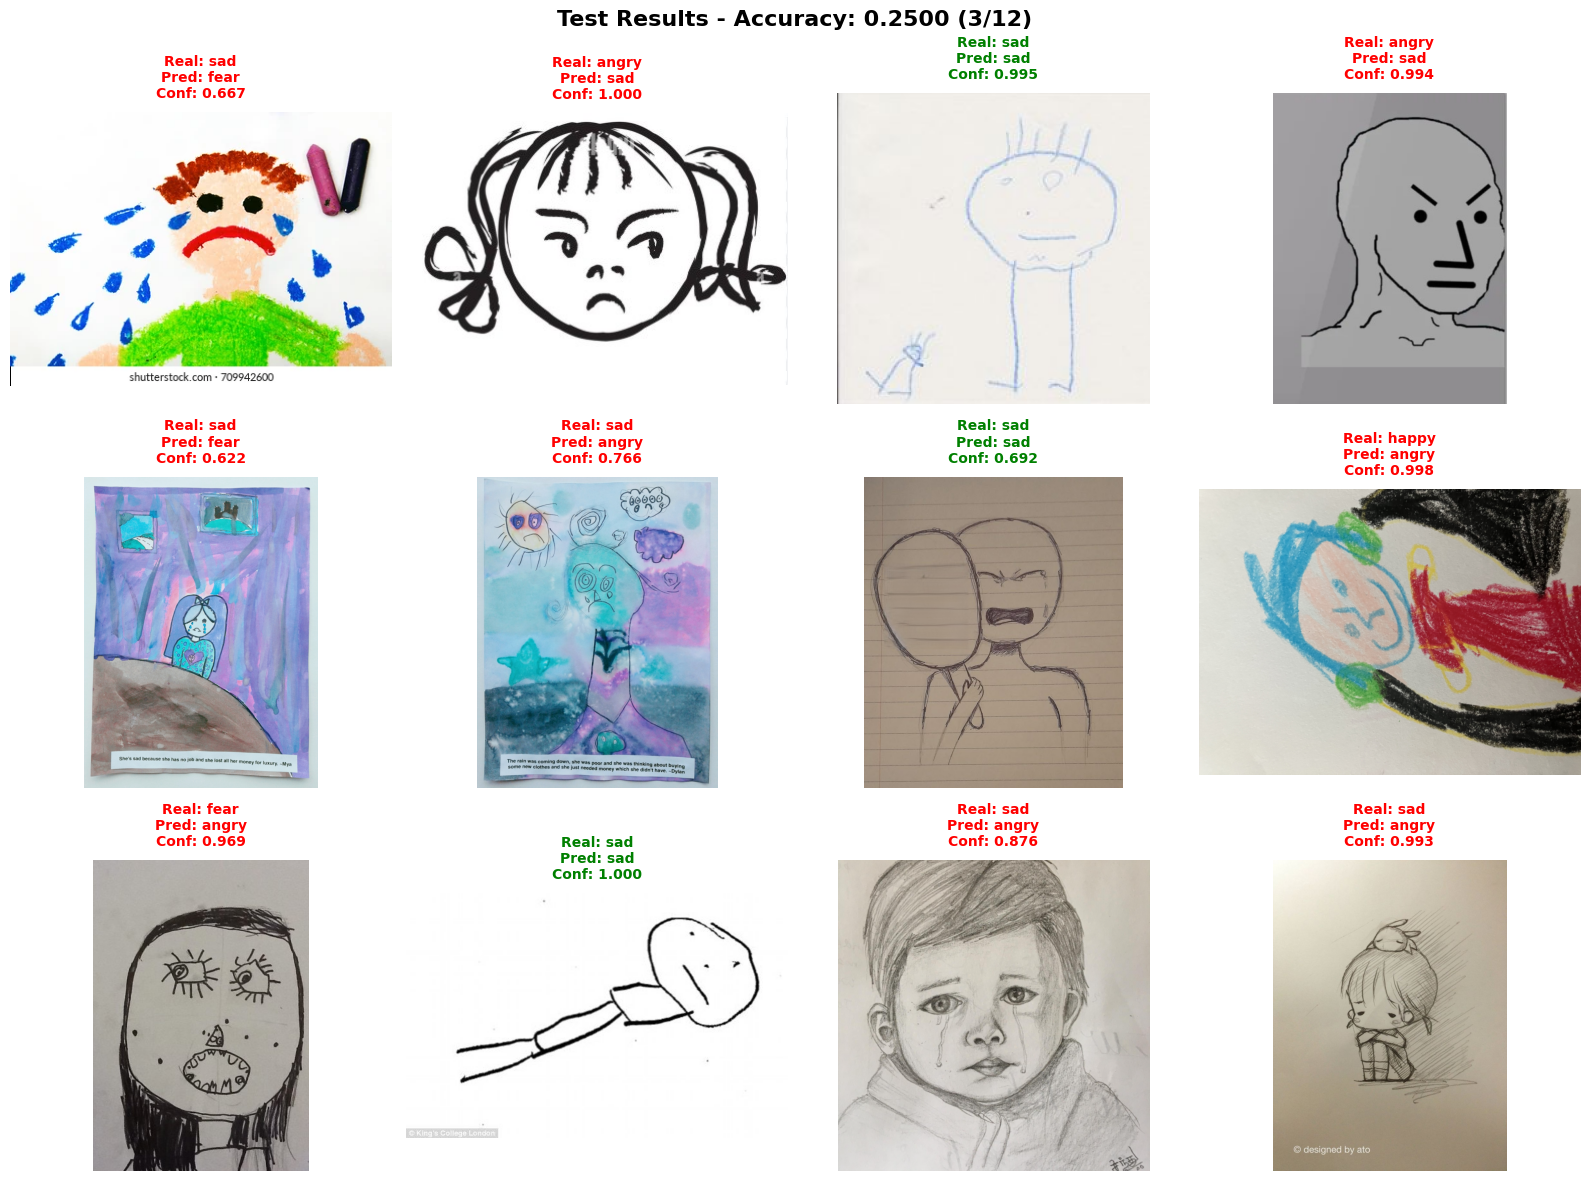


📋 상세 결과:
------------------------------------------------------------
❌  1. sad_25.jpg           | Real: sad             | Pred: fear            | Conf: 0.6666
❌  2. angry21.jpg          | Real: angry           | Pred: sad             | Conf: 0.9999
✅  3. sad_08.jpg           | Real: sad             | Pred: sad             | Conf: 0.9954
❌  4. angry10.jpg          | Real: angry           | Pred: sad             | Conf: 0.9935
❌  5. sad_13.jpg           | Real: sad             | Pred: fear            | Conf: 0.6224
❌  6. sad_11.jpg           | Real: sad             | Pred: angry           | Conf: 0.7659
✅  7. sad_21.jpg           | Real: sad             | Pred: sad             | Conf: 0.6922
❌  8. happy_02.jpg         | Real: happy           | Pred: angry           | Conf: 0.9982
❌  9. fear_5.jpg           | Real: fear            | Pred: angry           | Conf: 0.9694
✅ 10. sad_04.jpg           | Real: sad             | Pred: sad             | Conf: 0.9999
❌ 11. sad_26.jpg           | 

In [11]:
# 표시할 이미지 개수 설정
img_num = 12

# 테스트 이미지 시각화 함수
def visualize_test_results(model_path, test_folder_path, num_images=img_num):
    """
    테스트 폴더에서 이미지를 불러와서 예측 결과를 시각화
    """
    import random
    import math
    
    # 모델과 프로세서 로드
    print("🔄 모델 로딩 중...")
    model = SwinForImageClassification.from_pretrained(model_path)
    processor = AutoImageProcessor.from_pretrained(model_path)
    
    # 클래스 정보 로드
    with open(os.path.join(model_path, 'class_info.json'), 'r') as f:
        class_info = json.load(f)
    
    model.eval()
    model.to(DEVICE)
    
    # 테스트 이미지 수집
    test_images = []
    true_labels = []
    
    for class_name in os.listdir(test_folder_path):
        class_path = os.path.join(test_folder_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    test_images.append(os.path.join(class_path, img_name))
                    true_labels.append(class_name)
    
    # 랜덤하게 선택
    if len(test_images) > num_images:
        selected_indices = random.sample(range(len(test_images)), num_images)
        test_images = [test_images[i] for i in selected_indices]
        true_labels = [true_labels[i] for i in selected_indices]
    
    print(f"📊 {len(test_images)}개 테스트 이미지 처리 중...")
    
    # 예측 수행
    predictions = []
    confidences = []
    
    for img_path in test_images:
        # 이미지 로드 및 전처리
        image = Image.open(img_path).convert('RGB')
        inputs = processor(image, return_tensors="pt").to(DEVICE)
        
        # 추론
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            pred_idx = torch.argmax(probs, dim=-1).item()
            confidence = probs[0][pred_idx].item()
            
            pred_class = class_info['class_names'][pred_idx]
            predictions.append(pred_class)
            confidences.append(confidence)
    
    # 정확도 계산
    correct = sum(1 for true, pred in zip(true_labels, predictions) if true == pred)
    accuracy = correct / len(true_labels)
    
    print(f"🎯 테스트 정확도: {accuracy:.4f} ({correct}/{len(true_labels)})")
    
    # 동적으로 subplot 레이아웃 계산
    cols = 4  # 열 개수 고정
    rows = math.ceil(num_images / cols)
    
    # 시각화
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    fig.suptitle(f'Test Results - Accuracy: {accuracy:.4f} ({correct}/{len(true_labels)})', 
                 fontsize=16, fontweight='bold')
    
    # axes가 1차원인 경우 2차원으로 변환
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i, (img_path, true_label, pred_label, conf) in enumerate(zip(test_images, true_labels, predictions, confidences)):
        if i >= num_images:  # 설정한 개수만큼만 표시
            break
            
        row, col = i // cols, i % cols
        ax = axes[row, col]
        
        # 이미지 로드 및 표시
        image = Image.open(img_path).convert('RGB')
        ax.imshow(image)
        ax.axis('off')
        
        # 정답 여부에 따른 색상 설정
        color = 'green' if true_label == pred_label else 'red'
        
        # 라벨 텍스트 생성
        title = f"Real: {true_label}\nPred: {pred_label}\nConf: {conf:.3f}"
        ax.set_title(title, fontsize=10, color=color, fontweight='bold', pad=10)
        
        # 테두리 색상 설정
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
    
    # 빈 subplot 숨기기
    for i in range(len(test_images), rows * cols):
        row, col = i // cols, i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 상세 결과 출력
    print("\n📋 상세 결과:")
    print("-" * 60)
    for i, (img_path, true_label, pred_label, conf) in enumerate(zip(test_images, true_labels, predictions, confidences)):
        status = "✅" if true_label == pred_label else "❌"
        img_name = os.path.basename(img_path)
        print(f"{status} {i+1:2d}. {img_name:20s} | Real: {true_label:15s} | Pred: {pred_label:15s} | Conf: {conf:.4f}")
    
    return accuracy, true_labels, predictions, confidences

# 테스트 실행 예시
print(f"\n🔍 테스트 결과 시각화 ({img_num}개 이미지)")
print("=" * 50)

# 테스트 폴더가 존재하는지 확인
if os.path.exists(TEST_FOLDER_PATH):
    accuracy, true_labels, predictions, confidences = visualize_test_results(
        FINAL_MODEL_PATH, 
        TEST_FOLDER_PATH, 
        num_images=img_num
    )
    
    # 클래스별 성능 분석
    from collections import defaultdict
    
    class_stats = defaultdict(lambda: {'correct': 0, 'total': 0})
    
    for true_label, pred_label in zip(true_labels, predictions):
        class_stats[true_label]['total'] += 1
        if true_label == pred_label:
            class_stats[true_label]['correct'] += 1
    
    print("\n📊 클래스별 성능:")
    print("-" * 40)
    for class_name, stats in class_stats.items():
        class_acc = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
        print(f"{class_name:15s}: {class_acc:.4f} ({stats['correct']}/{stats['total']})")
    
else:
    print(f"❌ 테스트 폴더를 찾을 수 없습니다: {TEST_FOLDER_PATH}")

In [13]:
import torch
import torch.onnx
import onnx
import onnxruntime as ort
import numpy as np
from PIL import Image
import json
import os
from transformers import SwinForImageClassification, AutoImageProcessor

def convert_swin_to_onnx(model_path, output_path, optimize=True):
    """
    SWIN Transformer 모델을 ONNX 형태로 변환
    
    Args:
        model_path: 훈련된 모델이 저장된 경로
        output_path: ONNX 파일을 저장할 경로
        optimize: ONNX 모델 최적화 여부
    """
    print(f"🔄 모델 로딩 중: {model_path}")
    
    # 모델과 프로세서 로드
    model = SwinForImageClassification.from_pretrained(model_path)
    processor = AutoImageProcessor.from_pretrained(model_path)
    
    # 클래스 정보 로드
    with open(os.path.join(model_path, 'class_info.json'), 'r') as f:
        class_info = json.load(f)
    
    # 모델을 평가 모드로 설정
    model.eval()
    
    # 더미 입력 생성 (배치 크기 1, 3채널, 224x224)
    dummy_input = torch.randn(1, 3, 224, 224)
    
    # 입력/출력 이름 정의
    input_names = ['pixel_values']
    output_names = ['logits']
    
    # 동적 축 정의 (배치 크기를 동적으로 설정)
    dynamic_axes = {
        'pixel_values': {0: 'batch_size'},
        'logits': {0: 'batch_size'}
    }
    
    print("🚀 ONNX 변환 시작...")
    
    # ONNX 변환
    torch.onnx.export(
        model,
        dummy_input,
        output_path,
        input_names=input_names,
        output_names=output_names,
        dynamic_axes=dynamic_axes,
        opset_version=11,  # Unity 와 호환되는 opset 버전 체크할것
        do_constant_folding=True,
        verbose=False
    )
    
    print(f"✅ ONNX 모델 저장 완료: {output_path}")
    
    # ONNX 모델 검증
    print("🔍 ONNX 모델 검증 중...")
    onnx_model = onnx.load(output_path)
    onnx.checker.check_model(onnx_model)
    print("✅ ONNX 모델 검증 완료")
    
    # 최적화 (선택사항)
    if optimize:
        print("⚡ ONNX 모델 최적화 중...")
        optimized_path = output_path.replace('.onnx', '_optimized.onnx')
        
        # ONNX Runtime을 사용한 최적화
        sess_options = ort.SessionOptions()
        sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
        sess_options.optimized_model_filepath = optimized_path
        
        # 세션 생성 (최적화된 모델 자동 저장)
        session = ort.InferenceSession(output_path, sess_options)
        
        if os.path.exists(optimized_path):
            print(f"✅ 최적화된 ONNX 모델 저장: {optimized_path}")
        else:
            print("⚠️  최적화된 모델이 생성되지 않았습니다.")
    
    # 모델 정보 출력
    print("\n📊 모델 정보:")
    print(f"  - 입력 크기: {dummy_input.shape}")
    print(f"  - 출력 크기: {model.num_labels}")
    print(f"  - 클래스 수: {len(class_info['class_names'])}")
    print(f"  - 클래스 목록: {class_info['class_names']}")
    
    return output_path

def test_onnx_model(onnx_path, model_path, test_image_path=None):
    """
    ONNX 모델 테스트 및 원본 모델과 비교
    
    Args:
        onnx_path: ONNX 모델 경로
        model_path: 원본 모델 경로
        test_image_path: 테스트 이미지 경로 (선택사항)
    """
    print("\n🧪 ONNX 모델 테스트 시작...")
    
    # 원본 모델 로드
    original_model = SwinForImageClassification.from_pretrained(model_path)
    processor = AutoImageProcessor.from_pretrained(model_path)
    original_model.eval()
    
    # 클래스 정보 로드
    with open(os.path.join(model_path, 'class_info.json'), 'r') as f:
        class_info = json.load(f)
    
    # ONNX 모델 로드
    ort_session = ort.InferenceSession(onnx_path)
    
    # 테스트 이미지 준비
    if test_image_path and os.path.exists(test_image_path):
        print(f"🖼️  테스트 이미지 사용: {test_image_path}")
        test_image = Image.open(test_image_path).convert('RGB')
        inputs = processor(test_image, return_tensors="pt")
    else:
        print("🎲 랜덤 테스트 데이터 사용")
        inputs = {'pixel_values': torch.randn(1, 3, 224, 224)}
    
    # 원본 모델 예측
    with torch.no_grad():
        original_outputs = original_model(**inputs)
        original_logits = original_outputs.logits
        original_probs = torch.nn.functional.softmax(original_logits, dim=-1)
    
    # ONNX 모델 예측
    onnx_inputs = {ort_session.get_inputs()[0].name: inputs['pixel_values'].numpy()}
    onnx_outputs = ort_session.run(None, onnx_inputs)
    onnx_logits = torch.tensor(onnx_outputs[0])
    onnx_probs = torch.nn.functional.softmax(onnx_logits, dim=-1)
    
    # 결과 비교
    print("\n📊 예측 결과 비교:")
    print("-" * 50)
    
    # 원본 모델 결과
    original_pred = torch.argmax(original_probs, dim=-1).item()
    original_conf = original_probs[0][original_pred].item()
    print(f"원본 모델:")
    print(f"  - 예측 클래스: {class_info['class_names'][original_pred]}")
    print(f"  - 신뢰도: {original_conf:.4f}")
    
    # ONNX 모델 결과
    onnx_pred = torch.argmax(onnx_probs, dim=-1).item()
    onnx_conf = onnx_probs[0][onnx_pred].item()
    print(f"ONNX 모델:")
    print(f"  - 예측 클래스: {class_info['class_names'][onnx_pred]}")
    print(f"  - 신뢰도: {onnx_conf:.4f}")
    
    # 차이 계산
    logits_diff = torch.abs(original_logits - onnx_logits).max().item()
    probs_diff = torch.abs(original_probs - onnx_probs).max().item()
    
    print(f"\n🔍 정확도 비교:")
    print(f"  - Logits 최대 차이: {logits_diff:.6f}")
    print(f"  - Probabilities 최대 차이: {probs_diff:.6f}")
    print(f"  - 예측 일치: {'✅' if original_pred == onnx_pred else '❌'}")
    
    # 성능 측정
    print(f"\n⚡ 성능 비교:")
    
    # 원본 모델 속도 측정
    import time
    start_time = time.time()
    for _ in range(10):
        with torch.no_grad():
            _ = original_model(**inputs)
    original_time = (time.time() - start_time) / 10
    
    # ONNX 모델 속도 측정
    start_time = time.time()
    for _ in range(10):
        _ = ort_session.run(None, onnx_inputs)
    onnx_time = (time.time() - start_time) / 10
    
    print(f"  - 원본 모델: {original_time:.4f}초")
    print(f"  - ONNX 모델: {onnx_time:.4f}초")
    print(f"  - 속도 향상: {original_time/onnx_time:.2f}x")
    
    return original_pred == onnx_pred

def create_unity_metadata(model_path, onnx_path):
    """
    Unity에서 사용할 메타데이터 JSON 파일 생성
    """
    # 클래스 정보 로드
    with open(os.path.join(model_path, 'class_info.json'), 'r') as f:
        class_info = json.load(f)
    
    # Unity용 메타데이터 생성
    unity_metadata = {
        "model_info": {
            "name": "SWIN Transformer Drawing Classifier",
            "version": "1.0",
            "input_size": [224, 224, 3],
            "output_size": class_info['num_classes'],
            "mean": [0.485, 0.456, 0.406],  # ImageNet 평균
            "std": [0.229, 0.224, 0.225]    # ImageNet 표준편차
        },
        "classes": class_info['class_names'],
        "class_to_idx": class_info['class_to_idx'],
        "preprocessing": {
            "resize": 224,
            "center_crop": 224,
            "normalize": True,
            "to_tensor": True
        }
    }
    
    # 메타데이터 파일 저장
    metadata_path = onnx_path.replace('.onnx', '_metadata.json')
    with open(metadata_path, 'w', encoding='utf-8') as f:
        json.dump(unity_metadata, f, indent=2, ensure_ascii=False)
    
    print(f"📋 Unity 메타데이터 저장: {metadata_path}")
    return metadata_path

# 사용 예시
if __name__ == "__main__":
    # 경로 설정
    MODEL_PATH = "/workspace/models/drawing_finetuned_swin"  # 훈련된 모델 경로
    ONNX_OUTPUT_PATH = "/workspace/models/drawing_classifier.onnx"  # ONNX 저장 경로
    TEST_IMAGE_PATH = "/workspace/testImg/val/class_name/sample.jpg"  # 테스트 이미지 (선택사항)
    
    # 1. 모델을 ONNX로 변환
    print("🔄 SWIN Transformer → ONNX 변환 시작")
    print("=" * 50)
    
    try:
        onnx_path = convert_swin_to_onnx(
            model_path=MODEL_PATH,
            output_path=ONNX_OUTPUT_PATH,
            optimize=True
        )
        
        # 2. ONNX 모델 테스트
        test_success = test_onnx_model(
            onnx_path=onnx_path,
            model_path=MODEL_PATH,
            test_image_path=TEST_IMAGE_PATH if os.path.exists(TEST_IMAGE_PATH) else None
        )
        
        # 3. Unity 메타데이터 생성
        metadata_path = create_unity_metadata(MODEL_PATH, onnx_path)
        
        print(f"\n✅ 변환 완료!")
        print(f"📁 ONNX 모델: {onnx_path}")
        print(f"📁 메타데이터: {metadata_path}")
        
    except Exception as e:
        print(f"❌ 변환 실패: {str(e)}")
        import traceback
        traceback.print_exc()

🔄 SWIN Transformer → ONNX 변환 시작
🔄 모델 로딩 중: /workspace/models/drawing_finetuned_swin


🚀 ONNX 변환 시작...
✅ ONNX 모델 저장 완료: /workspace/models/drawing_classifier.onnx
🔍 ONNX 모델 검증 중...
✅ ONNX 모델 검증 완료
⚡ ONNX 모델 최적화 중...


2025-07-04 01:46:57.419552554 [W:onnxruntime:, inference_session.cc:2212 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.


✅ 최적화된 ONNX 모델 저장: /workspace/models/drawing_classifier_optimized.onnx

📊 모델 정보:
  - 입력 크기: torch.Size([1, 3, 224, 224])
  - 출력 크기: 4
  - 클래스 수: 4
  - 클래스 목록: ['angry', 'fear', 'happy', 'sad']

🧪 ONNX 모델 테스트 시작...
🎲 랜덤 테스트 데이터 사용

📊 예측 결과 비교:
--------------------------------------------------
원본 모델:
  - 예측 클래스: fear
  - 신뢰도: 0.3683
ONNX 모델:
  - 예측 클래스: fear
  - 신뢰도: 0.3683

🔍 정확도 비교:
  - Logits 최대 차이: 0.000001
  - Probabilities 최대 차이: 0.000000
  - 예측 일치: ✅

⚡ 성능 비교:
  - 원본 모델: 4.5303초
  - ONNX 모델: 3.1800초
  - 속도 향상: 1.42x
📋 Unity 메타데이터 저장: /workspace/models/drawing_classifier_metadata.json

✅ 변환 완료!
📁 ONNX 모델: /workspace/models/drawing_classifier.onnx
📁 메타데이터: /workspace/models/drawing_classifier_metadata.json
